# Labs 7 - 10: A CA model of Natural Disturbance
In [1990](https://doi.org/10.1016/0375-9601(90)90451-S) Bak, Chen and Tang proposed a cellular automaton that is an abstract model of a forest fire. Each cell is in one of three states: empty, occupied by forest, or on fire.

3 ecological processes are modelled: forest regeneration, fire ignition, and fire spread

  * empty cells "regenerate" forest at a fixed rate, $p$
  * forest fires ignite with a regular but small frequency, $f$
  * forested cells catch fire when their neighbours are burning, and burn out in one time step.

Over the remainder of term, we will develop 2D CA class that implements this model and run computational experiments on the spatial and temporal patterns that emerge.

In [66]:
%matplotlib inline
!pip install empiricaldist
from empiricaldist import Pmf

import time

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import animation
from scipy.stats import linregress
from scipy.signal import correlate2d
import random

# Configure matplotlib's animation library to work in the browser.
matplotlib.rc('animation', html='jshtml')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Helpers
Some useful, re-usable bits of code developed in previous notebooks...

In [67]:
DEFAULT_IMSHOW_OPTIONS = dict(
    cmap='Blues',
    interpolation='none',
    origin='upper',
)


def plot_2D_array(array, axes=None, title='', **options):
    """ Plot the 2D array as an image on the given axes  1's will be dark blue, 0's will be light blue. """
    axes = axes or plt.gca()  # If not axes are provided, draw on current axes
    axes.set_title(title)
    axes.set_xticks([], [])  # remove axes tick marks
    axes.set_yticks([], [])
    options = {**DEFAULT_IMSHOW_OPTIONS, **options}
    axes.imshow(array, **options)

In [68]:
class Animation2D:
    """
      Animates any 2D model with a step() method and a draw() method, using matplotlib
      model.step() should take no parameters - just step the model forward one step.
      model.draw() should take 2 parameters, the matpltolib axes to draw on and an integer step number

      See https://www.allendowney.com/blog/2019/07/25/matplotlib-animation-in-jupyter/
          for a discussion of the pros and cons of various animation techniques in jupyter notebooks
    """

    def __init__(self, model, frames=50, steps_per_frame=1, figsize=(8, 8)):
        """
        :param model: the simulation object to animate, with step() and draw(axes, step) methods
        :param frames: number of animation frames to generate
        """
        self.model = model
        self.frames = frames
        self.steps_per_frame = steps_per_frame
        self.fig, self.ax = plt.subplots(figsize=figsize)

    def animation_step(self, step):
        """ Step the model forward and draw the plot """
        if step > 0:
            for _ in range(self.steps_per_frame):
                self.model.step()
        self.model.draw(self.ax, step=step * self.steps_per_frame)

    def show(self):
        """ return the matplotlib animation object, ready for display """
        anim = animation.FuncAnimation(self.fig, self.animation_step, frames=self.frames)
        plt.close()  # this ensures the last frame is not shown as a separate plot
        return anim

    def animate(self, interval=None):
        """ Animate the model simulation directly in the notebook display block """
        from IPython.display import clear_output
        try:
            for i in range(self.frames):
                clear_output(wait=True)  # clear the IPython display
                self.ax.clear()  # clear old image from the axes (fixes a performance issue)
                plt.figure(self.fig)  # add the figure back to pyplot ** sigh **
                self.animation_step(i)
                plt.show()  # show the current animation frame (pyplot then closes and throws away figure ** sigh **)
                if interval:
                    time.sleep(interval)
        except KeyboardInterrupt:
            pass

# Lab 7:  Implementing the Bak, Chen, Tang Model

In this lab we will implement a 2D CA model using the same techniques as the GoL, Diffusion, and Percolation models.
We are setting up the model we will use in future labs to run some computational experiments to answer questions about this system.

## Ex. 7.1: Define the Cellular Automata
This 2D CA will be similar to those we've seen before.

1. Define the kernel (correlation matrix)
    * what do we need to know about a cell's neighbourhood?
    * how can we encode that using a dot product with a 3 x 3 correlation matrix?

2. The step function will be more complex because it must implement the 4 rules:

  *  An empty cell becomes occupied with probability $p$. #1
  *  A cell with a tree burns if any of its neighbors is on fire. #4
  *  A cell with a tree spontaneously burns, with probability $f$, even if none of its neighbors is on fire. #2
  *  A cell with a burning tree becomes an empty cell in the next time step. #3

Typical values for the parameters are $p=0.01$ and $f=0.001$

In [98]:
class ForestFire:
    """ 2D Cellular Automaton that simulates a fire-dominated landscape """

    # Define names for the 3 possible cell states
    EMPTY = 0
    OCCUPIED = 1
    FIRE = 5

    # Define a colour map that maps each cell state to an intuitive colour.
    cmap = [(1, 0.5, 0), (0, 1, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (1, 0, 0)]
    cmap[EMPTY] = (1, 0.5, 0)  # brown
    cmap[OCCUPIED] = (0, 1, 0)  # green
    cmap[FIRE] = (1, 0, 0)  # red
    forest_colour_map = matplotlib.colors.ListedColormap(cmap)

    # TODO: define a sensible correlation kernel
    kernel = np.array([[0, 1, 0],
                       [1, 1, 1],
                       [0, 1, 0]])


    def __init__(self, n, p=0.01, f=0.001, q=0.5):
        """Initializes the model.

        n: number of rows
        p: probability an empty cells becomes "forested" (occupied)
        f: probability of spontaneous file (e.g., 1/fire ignition interval)
        q: initial forest density (probability cell is "forested" in initial state)
        """
        self.n = n
        self.p = p
        self.f = f
        # initialize landscape with approx. q proportion of cells OCCUPIED
        self.array = np.random.choice([self.OCCUPIED, self.EMPTY], (n, n), p=[q, 1 - q])


    def step(self):
        """Executes one time step, applying the CA rules to regenerate and burn forest."""
        # TODO: define the rules for the CA.  This is a significant challenge b/c there are 4 rules and they must act independently!
        c = correlate2d(self.array, self.kernel, mode='same', boundary='wrap')
        fire = (self.array==self.OCCUPIED) & (c>=self.FIRE) #occupied cells with at least one occupied neighbour on fire
        empty = (self.array==self.EMPTY)
        occupied = (self.array==self.OCCUPIED)
        on_fire = (self.array==self.FIRE)
        self.array[empty] = np.random.choice([self.OCCUPIED, self.EMPTY], self.array[empty].shape, p=[self.p, 1-self.p]) #An empty cell becomes occupied with probability p
        self.array[occupied] = np.random.choice([self.OCCUPIED, self.FIRE], self.array[occupied].shape, p=[1-self.f, self.f]) #A cell with a tree spontaneously burns, with probability f, even if none of its neighbors is on fire
        self.array[on_fire] = self.EMPTY #A cell with a burning tree becomes an empty cell in the next time step
        self.array[fire] = self.FIRE #A cell with a tree burns if any of its neighbors is on fire


    def num_occupied(self):
        """ return the number of cells occupied by forest, includes cells that are currently on fire """
        occupied = (self.array==self.OCCUPIED)
        on_fire = (self.array==self.FIRE)
        return len(self.array[occupied]) + len(self.array[on_fire]) # TODO: count the number of forested cells.


    def pct_occupied(self):
        """ return the proportion of cells occupied by forest """
        return self.num_occupied() / self.array.size


    def draw(self, axes=None, step=''):
        """Draws the CA cells using the forest colour map so values are coloured intuitively."""
        axes = axes or plt.gca()
        title = f'Time:{step} Occupied: {round(self.pct_occupied() * 100, 2)}%'
        plot_2D_array(self.array, axes=axes, title=title,
                      cmap=self.forest_colour_map, vmin=0, vmax=len(self.forest_colour_map.colors))
    
test = ForestFire(3)
test.array = np.array([[0,0,5],
                       [1,0,1],
                       [0,1,1]])
print(test.num_occupied())
test.step()
print(test.array)
test.step()
print('\n')
print(test.array)

5
[[0 0 0]
 [1 0 5]
 [0 1 5]]


[[0 0 0]
 [5 0 0]
 [0 5 0]]


## Ex. 7.2: Animation
Create a simple animation (using Animate2D class provided) so we can visualize and verify the system dynamics

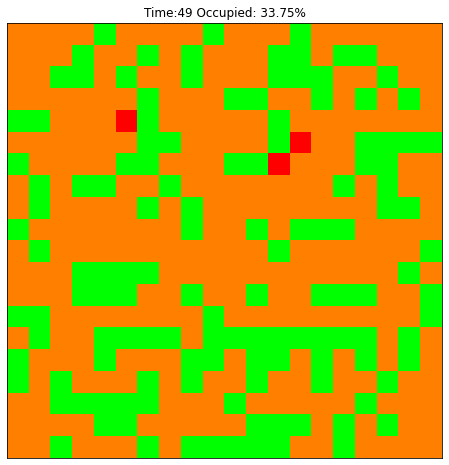

In [70]:
# Ex. 7.2 here
#  Suggestions: use a small grid (e.g., 20x20)  and
#               a short animation (100 frames) with interval=0.3, to slow it down so you can inspect its behaviour
anim_fire = Animation2D(ForestFire(20), 100)
anim_fire.animate(interval=0.3)

# Question 7.3:
In what ways is this model similar to Diffusion and/or Percolation?
What kinds of behaviours might we predict from this more complex model based on what we learned from the simpler Diffusion and/or Precolation models?
Provide concise (brief, point-form) answers below:

## Answers:
####Percolation:
*   Can only occur in certain cells (the green)
*   Cannot occur in the orange cells, as they are not inhabited

#### Diffusion:
*   Spreads out from a single cell
*   The middle cell is 'extinguished' once the fire spreads out





-------------------

# Lab 8:  Temporal Dynamics: Stability and Equilibrium

The [dynamics](https://en.wikipedia.org/wiki/System_dynamics) of a system describe how it changes over time.  In mathematics, we typically express dyanamics with differential equations (i.e., expressing change over time).  In computation, we typically use a simulation model, like the one developed in Lab 7.

Please watch: [Basic System Dyanmics (15 min)](https://youtu.be/qlRM1JlxfkU) for a quick introduction to these concepts.

---------------------
In this lab we will explore the patterns our `ForestFire` model traces out over time.  We'll try to determine if the model is stable or chaotic, whether there are any circumstances where it reaches [equilibirum](https://en.wikipedia.org/wiki/Mechanical_equilibrium)

## Ex. 8.1: Exploratory Analysis
Explore the behaviour of the model we defined above.
 1. Alter the model's initial conditions - how does the behaviour change depending on the initial proportion of forested vs. empty cells?
 2. Alter the regeneration and fire frequency parameters, $p$ and $f$, to see how this changes the model behaviour - how does the behaviour change as you increase or decrease each of these model parameters?

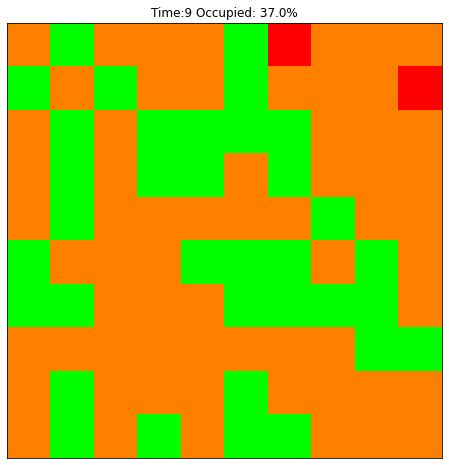

In [71]:
# Ex. 8.1 here
frames = 50
exploratory_fire = ForestFire(10, p=0.1, f=0.01, q=0.5)
anim_fire = Animation2D(exploratory_fire, frames)
anim_fire.animate(interval=0.15)

1. When the q value (the initial probability of a cell being 'inhabited') is very high (0.8 in my experimentation), the forest is destroyed almost totally right away. The reason for this is because it is more likely that a cell has a neighbour that is on fire, meaining it will be on fire in the next time-step. The reason for this is found in the code, a cell has a 0.1% chance of being randomly set ablaze, but only if there is vegetation in it, meaning the more vegetation, the more chances for that 1 in 1000 chance to occur. The opposite occurs with a low q value, the initial forest stays for longer, allowing it to grow.
2. When both the p and f values are very low, the forest becomes very stable, with no growth or shrinkage occuring (almost no vegetation grows, and almost no fire occurs). When they are increased ten fold (p = 0.1, f= 0.01), there appears an almost constant period of both growth and fire, to the point it never settles into a stable state

## Ex. 8.2: Steady State
Many complex systems never achieve a static [equilibirum](https://en.wikipedia.org/wiki/Mechanical_equilibrium), instead their state fluctuates around a value, called an ["attractor"](https://en.wikipedia.org/wiki/Attractor).  A system that is not trending is said to be in ["steady state"](https://en.wikipedia.org/wiki/Steady_state).
Starting from a random initial condition, run the model until it reaches a "steady state" where the number of occupied cells is no longer trending (consistently increasing or decreasing).

Design an experimental setup that allows you to detect when the system is in steady state with respect to the number of forested cells.
This need not be fancy and need not automate the detection of steady state, so long as it provides some output that allows you to detect how long it takes for the system to settle into an equilibrium or cyclical pattern.

0.2888545043478261

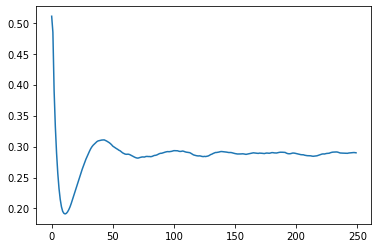

In [72]:
# Ex. 8.2 here
frames = 250
s = ForestFire(500, p=0.015, f=0.0015)
perc_occupied = []
for i in range(frames):
  s.step()
  perc_occupied.append(s.pct_occupied())

plt.plot(range(frames), perc_occupied)
np.average(perc_occupied[20:])

### Question 8.3:
Starting with a uniform random landscape, $q$ = 0.5, find the steady state proportion of forested cells of this system for 3 different combinations of $p$ and $f$, and the approx. number of time steps required to reach steady state.
Fill in the table below with your experimental results:

| p  | f   | steady-state | time steps | Cyclical? |
|----|-----|--------------|------------|-----------|
| 0.01 | 0.001 | Yes        | 200          | Yes         |
| 0.1  | 0.01   | Yes            | 35          | Yes         |
| 0.015  | 0.0015   | Yes            | 100          | Yes         |


## Ex. 8.4: Stability
A system is ["stable"](https://en.wikipedia.org/wiki/Ecological_stability) if it returns to its former steady state after a [disturbance](https://en.wikipedia.org/wiki/Disturbance_(ecology))

A disturbance in our case might be an extreme fire year or an insect outbreak that changes the forest's susceptibility to fire, or several years of reduced regeneration due to a soil fungus killing seedlings.
How could you emulate a disturbance like this in your model?  If you want to modify the model in some way, that's OK, but you may also find ways to emulate a disturbance as an "external forcing function".

Run your model to steady-state, then emulate a major disturbance (over one or more time steps) to "perturb" the system away from its steady state.  Remove the external force and measure how long it takes for the system to return to steady state.

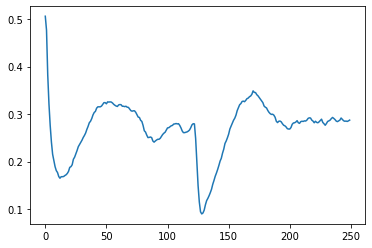

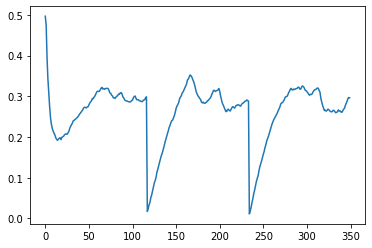

In [73]:
# Ex. 8.4 here
s = ForestFire(50, p=0.01, f=0.001)
perc_occupied = []
disaster_years = [122,123,124,125,126]
for i in range(frames):
  if i in disaster_years:
    s.f = 0.1
  else:
    s.f = 0.001
  s.step()
  perc_occupied.append(s.pct_occupied())
highfire = plt.plot(range(frames), perc_occupied)
plt.show()
frames = 350
t = ForestFire(50, p=0.01, f=0.001)
perc_occupied = []
for i in range(frames):
  if i == frames//3 or i ==2*frames//3:
    t.f = 1
  else:
    t.f = 0.001
  t.step()
  perc_occupied.append(t.pct_occupied())
low_growth = plt.plot(range(frames), perc_occupied)
plt.show()

### Question 8.4:
Does the model tend to return to the same steady-state, or does the attractor move to a different value?
How long does it take for the model to return to steady-state dynamics?
Does it appear to matter to these results how large the disturbance is?
What does that tell you about the number of "attractors" in this system?

#### Answers:
The models return to about the same steady-state, though there is a slight elevation in both models in the years immedieately after the disaster year(s). It seems to take about 10 years for the simulations to revert back to complete normal. No matter what the size of the disturbance is, as one of the simulations is simulating a forestfire destroying the whole forest, it returs back to its pre-disaster level. 

-----------------

# Lab 9: Patch Size Distribution

The spatial patterns that emerge from this model tends to be landscapes with patches of forested and un-forested land of varying size.  A question naturally arises about this pattern:
  * what is the size of patches created by fire?
    This will alos tell us something about forest [fragmentation](https://en.wikipedia.org/wiki/Habitat_fragmentation), which impacts wildlife habitat, for example.

Notice that rather than a single number, we will get a [distribution](https://en.wikipedia.org/wiki/Probability_distribution) of values for patch sizes.  The shape of this distribution emerges from the system dynamics, and serves as a way to compare our model results with empirical observations of patch-size distributions in real ecosystems.

In this lab we will explore the spatial patterns our `ForestFire` model makes.  We'll ask if these patterns have a [heavy-tail distribution](https://en.wikipedia.org/wiki/Heavy-tailed_distribution) and thus exhibit [self-organizing criticality](https://en.wikipedia.org/wiki/Self-organized_criticality)

### Identifying Contiguous Patches

This is a surprisingly challenging problem to solve in the general case given how good our visual system is at identifying them!
The idea I had here was to start by giving each forested cell a unique value, then "grow" patches by allowing the smallest of these unique values to propagate to neighbouring cells.  Repeat until the propagation is finished.  In the end, all the cells in each contiguous patch have the same, unique identifier.
Notice that this is a modified diffusion / percolation algorithm - they are actually useful!

In [74]:
neighbourhood = np.array([
    [0, 1, 0],
    [1, 1, 1],
    [0, 1, 0],
])


def min_neighbour(a):
    """ Return the smallest non-zero neighbourhood value or 0 if centre cell is a zero """
    p = a * neighbourhood
    centre = tuple(d // 2 for d in a.shape)
    return np.min(p[p > 0]) if a[centre] else 0


def consolidate(array):
    """ return copy of array with adjacent cells consolidated into a patch with the lowest value among occupied neighbours """
    rows, cols = array.shape
    k = neighbourhood.shape[0]
    array = np.pad(array, 1, 'constant')
    return np.array([
        [min_neighbour(array[row:row + k, col:col + k]) for col in range(cols)]
        for row in range(rows)
    ])


def patchify(array, patch_category):
    """ Return an array with each contiguous patch identified by a unique integer
    array:  array of int categorical values
    category: the category value to identify patches for

    return: array of same shape with a unique value identifying cells in each patch and zeros elsewhere
    """
    patches = np.zeros(array.shape, dtype=np.uint)
    # assign each cell that falls in a patch a unique number, 1 .. N
    patches[array == patch_category] = range(1, len(array[array == patch_category]) + 1)

    patches_growing = np.array([True, ])
    while np.any(patches_growing):
        prev_patches = patches
        patches = consolidate(prev_patches)
        patches_growing = patches != prev_patches  # patches are growning until consolidate algorithm stabilizes.

    return patches

#A Frequency Distribution Class
You might notice some code duplicated in each of the experiments above to take convert the experimental observations, compute the frequency distribution, and plot it. Let's package that logic up for re-use.

Note: the textbook author published a more full-featured (and efficient!) version of this class called empiricaldist on PyPi

In [75]:
class FrequencyDist:
    """ Represents the Frequency Distribution for a set of observations on a discrete random variable """
    def __init__(self, observations, labels: dict=None, title='Trials'):
        """ observations is a 1D sequence of empirical data, labels optionally relabel observation values """
        self.n_obs = len(observations)
        self.title = title
        # sort categories in same order as labels dict, if provided
        key = (lambda v: list(labels.keys()).index(v)) if labels else None
        self.categories = sorted(set(observations), key=key)
        self.n_cat = len(self.categories)

        # frequencies and matching category labels
        self.counts = np.array([sum(1 for sample in observations if sample == category) for category in self.categories])
        self.proportions = self.counts/self.n_obs
        self.category_labels = tuple(labels[c] for c in self.categories) if labels else self.categories

    def get_frequencies(self):
        """ Return the frequency count of each category as a dict """
        return {
            cat: freq for cat, freq in zip(self.category_labels, self.counts)
        }

    def print_frequencies(self):
        """ Print the frequency of each category as a fraction of observations """
        print(f'{self.title}:', [f'p({o})=", {n}/{self.n_obs}' for o, n in self.get_frequencies().items()] )

    def bar(self, axes=None, **options):
        """ Plot distribution as a bar chart. """
        axes = axes or plt.gca()  # If no axes are provided, draw on current axes
        axes.set(**options)
        axes.set_title(f'Frequency distribution for {self.n_obs} {self.title}')
        axes.bar(self.category_labels, self.proportions)

    def plot(self, axes=None, **options):
        """ Plot distribution as a line graph. """
        axes = axes or plt.gca()  # If no axes are provided, draw on current axes
        axes.set(**options)
        axes.set_title(f'Frequency distribution for {self.n_obs} {self.title}')
        axes.plot(self.categories, self.proportions)

## Ex. 9.1 Patch Size Distribution

Run your model to steady-state, and `patchify` the model state.
You might want to plot these beside each other to verify that `patchify` is working as expected.

With a unique value assigned to each patch, we can tally up the size of each patch simply by counting the number of cells for each unique value.
*Tip*: use [numpy.unique](https://numpy.org/doc/stable/reference/generated/numpy.unique.html), with `return_counts=True`, which does exactly the job we want.

Once you have an array of patch-size counts, create a histogram to display the distribution of patch sizes.
You could feed the raw patch-size count data to [pyplot.hist](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html), but you'll get a much nicer graph if you tally the number of patches in each size class yourself and use [pyplot.bar](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.bar.html) to do the plotting.
*Tip*: `np.unique` will also tally up the number of patches in each size class from the patch-size array!

In [76]:
# Ex. 9.1 here
steady_state = ForestFire(100)
for i in range(200):
  steady_state.step()
# steady_state.draw()
# print(steady_state.array)
patched = patchify(steady_state.array, steady_state.OCCUPIED)
# print(patched)
u_patched = np.unique(patched[patched>0], return_counts=True)
u_patched
# steady_state.draw()

(array([1.000e+00, 2.000e+00, 4.000e+00, ..., 2.870e+03, 2.872e+03,
        2.874e+03]), array([1, 2, 1, ..., 1, 2, 1]))

In [77]:
print(u_patched)
u_patched = u_patched
len(u_patched[0])

(array([1.000e+00, 2.000e+00, 4.000e+00, ..., 2.870e+03, 2.872e+03,
       2.874e+03]), array([1, 2, 1, ..., 1, 2, 1]))


1122

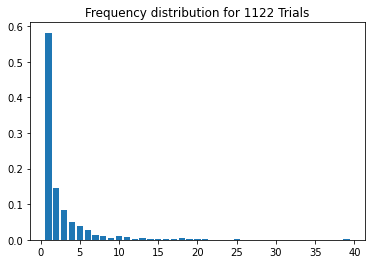

In [78]:
dist = FrequencyDist(u_patched[1])
dist.bar()

## Ex. 9.2 Heavy-tailed distribution?
The textbook author published a small Python package that encapsulates some of the work we did above to compute the "empirical distribution" from an array of data.  In paricular, his `PMF()` ([Probability Mass Function](https://en.wikipedia.org/wiki/Probability_mass_function)) function converts an array of unique values into an emirical distribution suitable for plotting

You can see how this function is used in Ch. 10.5.
And/Or check how it is used in the [chap10.ipynb notebook](https://github.com/pearcej/complex-colab/blob/master/notebooks/chap10.ipynb) in the complex-colab repo.
And/Or look at the [API Documentation](https://nbviewer.org/github/AllenDowney/empiricaldist/blob/master/empiricaldist/dist_demo.ipynb)

Create a plot of the patch size distribution, both on a linear and log-log scale, similar to the example in Ch. 10.5

<Axes: >

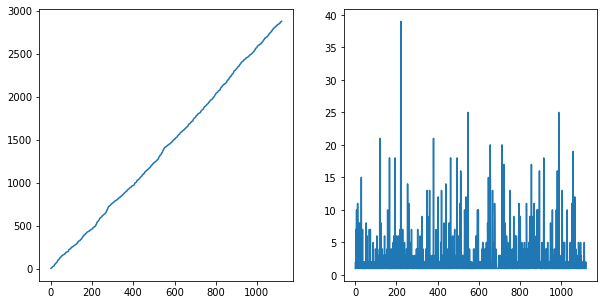

In [79]:
# Ex. 9.2 here
T,S = u_patched
T = T[T>1]
S = S[S>0]
pmfT = Pmf(T)
pmfS = Pmf(S)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
pmfT.plot(label='T')

plt.subplot(1, 2, 2)
pmfS.plot(label='S')

[-1.]


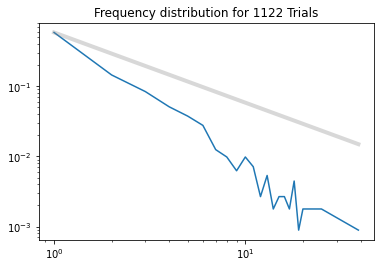

In [80]:
def slope(xs, ys):
    """ Return slope in log-space """
    return np.diff(np.log(ys)) / np.diff(np.log(xs))

def plot_negative_one_slope(dist, axes=None):
    """ Plot a line with slope -1 from the first point in the dist """
    axes = axes or plt.gca()
    xs = [dist.categories[0], dist.categories[-1]]
    ys = [dist.proportions[0], 0]
    ys[1] = ys[0] * np.exp(-1*np.log(xs[1]/xs[0]))  # compute y1 so line has a slope exactly -1 in log space
    # assert slope(xs, ys) == -1                      # double check that line has slope -1 in log space
    print(slope(xs,ys))
    axes.plot(xs, ys, color='gray', alpha=0.3, linewidth=4)

# dist is a FrequencyDistribution object
_, ax = plt.subplots(figsize=(6, 4))
dist.plot(ax, xscale='log', yscale='log')
plot_negative_one_slope(dist, ax)

### Question 9.3

Does the patch size distribution appear to follow the power law?
Does it show any signs of being a "heavy-tailed" distribution?
If it does, what might the implications be for our understanding of the dynamics of real forest ecosystems?

#### Answers

As you can see in the graph of 9.1, the frequency distribution graph follows the power law, as it tails off drastically after the first 5 or so bars of the graph. In additon to following the power law, there is no "heavy-tailed distribution", meaning that there is not sudden increase twoards the end of the graph, instead it slowly heads towards zero.

---------------------

# Lab 10:  Fractal Dimension

I highly recommend you start with this [**_2Blue1Brown Video_**](https://youtu.be/gB9n2gHsHN4), if you've not yet seen it.

-----------------
In this lab we will calculate the [fractal dimension](https://en.wikipedia.org/wiki/Fractal_dimension) of the forested areas thatour `ForestFire` model generates.

## Ex. 10.1 Box Counting

We'll use the [box counting](https://en.wikipedia.org/wiki/Box_counting) algorithm, which, in essence, estimates how the measured amount of forested area scales at different sized counting grids (2D rulers).  You are welcome to pilfer the `box_count` code developed for measuring fractal dimension in the **Precolation** model.

Run your model forward to steady-state, and use the box counting algorithm to estimate how the pattern of forested patches scales.  The result here show how the count of "forested" cells scales with the size of the "box" (grid cell) used to do the counting.
Just looking at the results, do you think this is closer to a linear or a squared scaling factor?

Occupied cell counts by window calibre: {5: 399, 10: 100, 15: 36, 20: 25, 25: 16, 30: 9, 35: 4, 40: 4, 45: 4, 50: 4}


<BarContainer object of 10 artists>

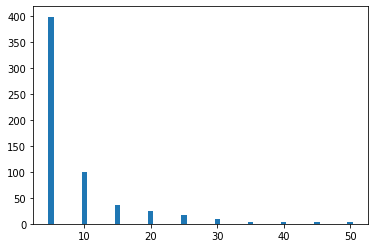

In [81]:
# Ex. 10.1 here
def box_count(array, calibre, target=ForestFire.OCCUPIED):
    """
    Tile the 2D array with a grid of square windows of given calibre,
     return number of windows in the grid that contain at least one target cell
    """
    rows,cols = array.shape
    grid = (array[i:i+calibre, j:j+calibre] for i in range(0, rows-calibre+1, calibre) for j in range(0, cols-calibre+1, calibre))
    return sum(target in window for window in grid)

calibres = np.array([5, 10, 15, 20, 25, 30, 35, 40, 45, 50])
ss_box_counts = [box_count(steady_state.array, calibre) for calibre in calibres] # I already had a Forest Fire simulation ran to steady state, so i called that here instead of creating another one
print(f'Occupied cell counts by window calibre: {dict((cal, cnt) for cal,cnt in zip(calibres, ss_box_counts))}')
plt.bar(calibres, ss_box_counts)

## Ex. 10.2  Estimate Fractal Dimension

If we plot the count of forested cells versus the size of the "box" on a log-log scale, the slope estimates the fractal dimension.

Estimate the slope of your box-count data using a log-log linear regression (again, feel free to pilfer the `log_slope` function).
Plot the graph that shows the box-count data in relation to a simple linear and square scaling relation (again, pilfer code as needed).

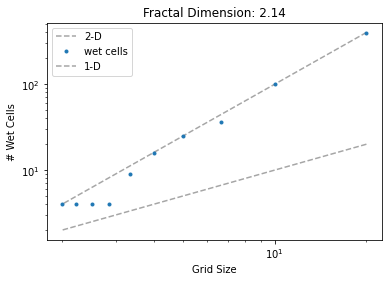

In [88]:
# Ex. 10.2 here
def log_slope(xs, ys):
    """ Estimate the slope of log-space plot of data points using linear regression """
    slope,*_ = linregress(np.log(xs), np.log(ys))
    return slope

def plot_scaling(perc, calibres):
    """
    Plot how the number of wet cells in the given perc model scales
    Compare this plot to 1D (y = x) and 2D (y = x**2) scaling factors
    """
    # calibres = calibres or np.array(range(2, perc.n//2, 10))
    wet_counts = np.array([box_count(perc.array, calibre) for calibre in calibres])
    xs = perc.n / calibres  # xs are the number of grid squares so they scale in same direction as counts

    line_options = dict(linestyle='dashed', color='gray', alpha=0.7)
    plt.plot(xs, xs**2, label='2-D', **line_options)              # y =  x**2
    plt.plot(xs, wet_counts, '.', label=f'wet cells')             # y = 1 / wet cell count for window size x
    plt.plot(xs, xs, label='1-D', **line_options)                 # y = x

    title = f'Fractal Dimension: {log_slope(xs, wet_counts):0.2f}'
    plt.gca().set(title=title, xlabel='Grid Size', ylabel='# Wet Cells', xscale='log', yscale='log')
    plt.legend()



log_slope(steady_state.n/calibres, ss_box_counts)
plot_scaling(steady_state, calibres=calibres)

## Ex. 10.3  Scaling Experiment

In our study of Percolation patterns, we plotted the scaling factor and fractal dimension to visualize how the pattern scales compared to simple linear and square scaling.  We set up an experiment to explore how fractal dimension changed for different model paraemter values, and to idenify a critical values where [phase transitions](https://en.wikipedia.org/wiki/Phase_transition) occur.

Repeat these experiments for the `ForestFire` model.  Again, you may adapt the code developed for Percolation.

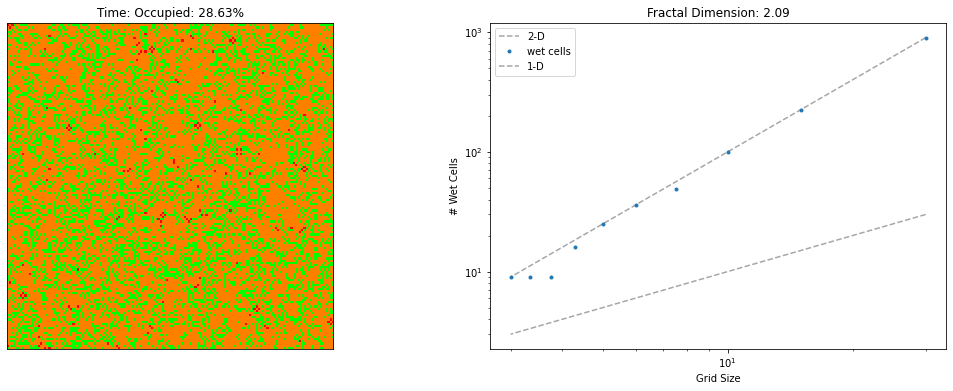

In [99]:
# Ex. 10.3 here
def scaling_experiment(n, q):
    """ Run an experiment to calculate and plot the fractal dimension of Percolation(n, q) """
    perc = ForestFire(n, q=q)
    for i in range(200):
      perc.step()

    plt.subplots(1, 2, figsize=(18, 6))
    plt.subplot(1, 2, 1)
    perc.draw()
    plt.subplot(1, 2, 2)
    plot_scaling(perc, calibres)
n=150
q=0.6
scaling_experiment(n,q)

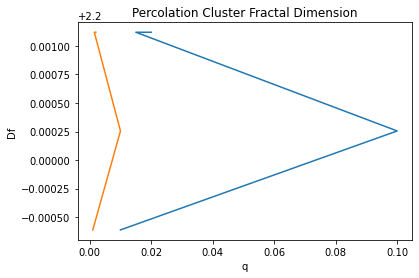

In [106]:
def fractal_dimensions_experiment(qs, n=100):
    """
    Plot how the fractal dimension of percolation clusters change for different values of q
    """
    calibres = np.array(range(5, n//2, 5))
    fractal_dimensions = []
    for p,f in qs:
        perc = ForestFire(n, p = p, f=f)
        for i in range(200):
          perc.step()
        wet_counts = np.array([box_count(perc.array, calibre) for calibre in calibres])
        xs = perc.n / calibres  # xs are the number of grid squares so counts scale in same direction

        fractal_dimensions.append( log_slope(xs, wet_counts) )
    return fractal_dimensions

n = 100
p_and_f = [(0.01,0.001), (0.1,0.01), (0.015, 0.0015), (0.02,0.002)] # separate into two for graphing?
dims = fractal_dimensions_experiment(p_and_f, n)
title = f'Percolation Cluster Fractal Dimension'
plt.gca().set(title=title, xlabel='q', ylabel='Df')
plt.plot(p_and_f, dims)
plt.show()

### Question 10.4:
How does the fractal dimension change for different values of $p$ and $f$?
Does there appear to be a critical value where the fractal dimension goes through a phase change, like we saw for Percolation?
What conclusions might your draw about the complexity of forest edges in real forest ecosystems?  How does this compare the the man-made edges that typically result from industrial logging?

#### Answers: